<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/MachineLeaning/blob/main/mamba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelectiveScan(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv

        # A, B, C, D matrices for selective scan
        self.A = nn.Parameter(torch.randn(d_model, d_state) / math.sqrt(d_model))
        self.B = nn.Parameter(torch.randn(d_model, d_state) / math.sqrt(d_model))
        self.C = nn.Parameter(torch.randn(d_model, d_state) / math.sqrt(d_model))
        self.D = nn.Parameter(torch.randn(d_model) / math.sqrt(d_model))

        # Convolution layers
        self.conv = nn.Conv1d(d_model, d_model, d_conv, padding='same', groups=d_model)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        B, L, D = x.shape

        # Compute ∆ (delta)
        delta = torch.sigmoid(self.conv(x.transpose(1, 2)).transpose(1, 2))

        # Initialize state
        h = torch.zeros(B, self.d_state, device=x.device)
        outputs = []

        # Selective scan
        for i in range(L):
            # Update state
            h = h + torch.einsum('bd,dm->bm', x[:, i], self.A)

            # Compute output
            y = torch.einsum('bm,dm->bd', h, self.C) + self.D * x[:, i]
            outputs.append(y)

            # Apply delta update
            # The original line was: h = h * (1 - delta[:, i].unsqueeze(-1))
            # The issue was a shape mismatch. delta[:, i].unsqueeze(-1) has shape (batch_size, 1, d_model),
            # while h has shape (batch_size, d_state).
            # We need to make sure the shapes are compatible for element-wise multiplication.
            # Assuming delta is meant to act as a gate on the hidden state, we can
            # reduce the dimension of delta to match h:
            h = h * (1 - delta[:, i, :self.d_state])

        return torch.stack(outputs, dim=1)

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.selective_scan = SelectiveScan(d_model, d_state, d_conv)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.selective_scan(x)
        x = self.dropout(x)
        return x + residual

class MambaModel(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_model=256,
                 d_state=16,
                 d_conv=4,
                 n_layers=4,
                 dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            MambaBlock(d_model, d_state, d_conv, dropout)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        x = self.fc(x)

        return x

# 학습 및 추론을 위한 유틸리티 함수들
def train_step(model, optimizer, criterion, x, y):
    model.train()
    optimizer.zero_grad()

    output = model(x)
    loss = criterion(output.view(-1, output.size(-1)), y.view(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate(model, criterion, x, y):
    model.eval()
    with torch.no_grad():
        output = model(x)
        loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
    return loss.item()

# 사용 예시
def main():
    # 하이퍼파라미터
    vocab_size = 10000
    d_model = 256
    d_state = 16
    d_conv = 4
    n_layers = 4
    batch_size = 32
    seq_length = 128

    # 모델 초기화
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MambaModel(
        vocab_size=vocab_size,
        d_model=d_model,
        d_state=d_state,
        d_conv=d_conv,
        n_layers=n_layers
    ).to(device)

    # 옵티마이저와 손실 함수
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # 더미 데이터 생성
    x = torch.randint(0, vocab_size, (batch_size, seq_length)).to(device)
    y = torch.randint(0, vocab_size, (batch_size, seq_length)).to(device)

    # 학습 루프
    n_epochs = 5
    for epoch in range(n_epochs):
        loss = train_step(model, optimizer, criterion, x, y)
        eval_loss = evaluate(model, criterion, x, y)
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train loss: {loss:.4f}")
        print(f"Eval loss: {eval_loss:.4f}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch 1/5
Train loss: 9.3758
Eval loss: 9.1670
Epoch 2/5
Train loss: 9.1711
Eval loss: 8.9602
Epoch 3/5
Train loss: 8.9666
Eval loss: 8.7544
Epoch 4/5
Train loss: 8.7668
Eval loss: 8.5491
Epoch 5/5
Train loss: 8.5633
Eval loss: 8.3437


[*********************100%***********************]  1 of 1 completed


Epoch 10/50:
Train Loss: 0.0072
Val Loss: 0.0050
Epoch 20/50:
Train Loss: 0.0033
Val Loss: 0.0073
Early stopping triggered


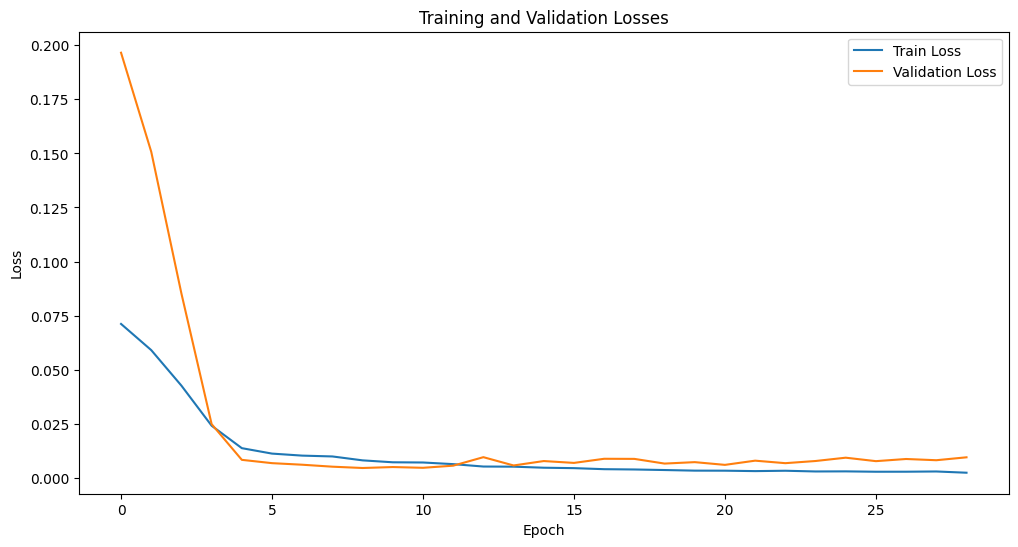

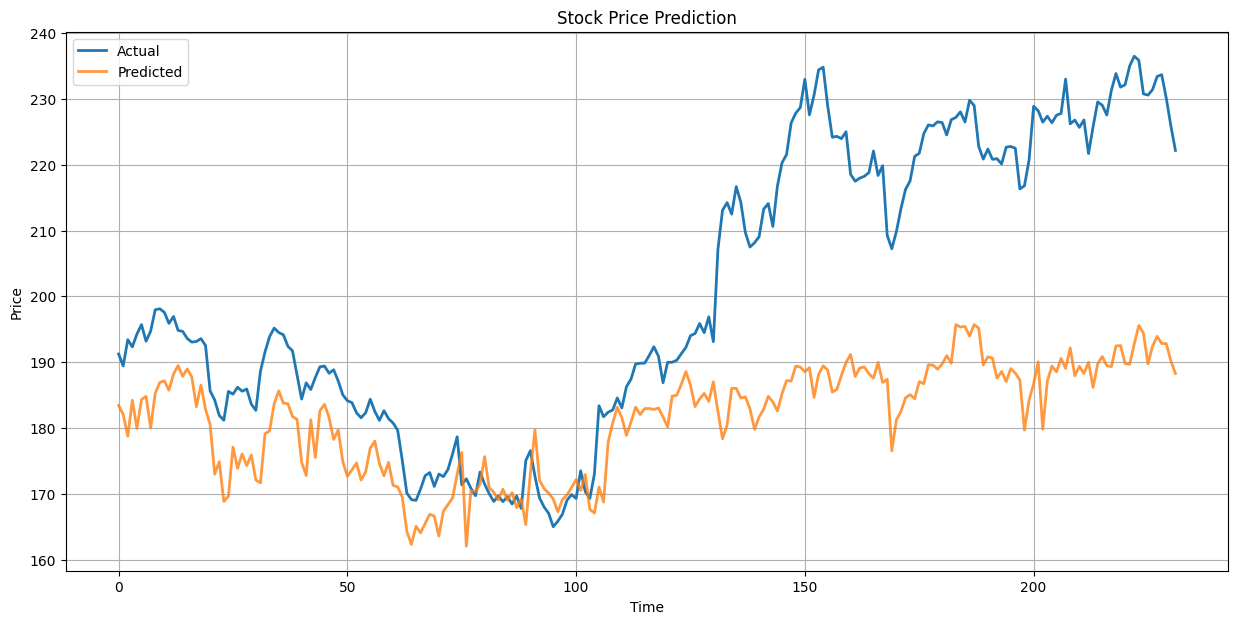


Performance Metrics:
MSE: 590.05
RMSE: 24.29
MAE: 19.40
MAPE: 9.03%


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class SelectiveScan(nn.Module):
    def __init__(self, d_model, d_state=32):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state

        # 입력 프로젝션
        self.in_proj = nn.Linear(d_model, d_state)

        # 상태 업데이트를 위한 게이트
        self.gate = nn.Linear(d_model, d_state)

        # 출력 프로젝션
        self.out_proj = nn.Linear(d_state, d_model)

    def forward(self, x):
        B, L, D = x.shape

        # 입력을 상태 공간으로 프로젝션
        x_state = self.in_proj(x)  # [B, L, d_state]

        # 게이트 값 계산
        gate = torch.sigmoid(self.gate(x))  # [B, L, d_state]

        # 상태 초기화
        h = torch.zeros(B, self.d_state, device=x.device)
        outputs = []

        for i in range(L):
            # 상태 업데이트
            h = h * (1 - gate[:, i]) + x_state[:, i] * gate[:, i]

            # 출력 생성
            y = self.out_proj(h)
            outputs.append(y)

        return torch.stack(outputs, dim=1)

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=32, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.selective_scan = SelectiveScan(d_model, d_state)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.selective_scan(x)
        x = self.dropout(x)
        return x + residual

class StockMambaModel(nn.Module):
    def __init__(self, input_size, d_model=128, d_state=64, n_layers=8, dropout=0.2):
        super().__init__()

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_size, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Mamba layers
        self.layers = nn.ModuleList([
            MambaBlock(d_model, d_state, dropout)
            for _ in range(n_layers)
        ])

        # Output projection
        self.norm = nn.LayerNorm(d_model)
        self.hidden1 = nn.Linear(d_model, d_model//2)
        self.hidden2 = nn.Linear(d_model//2, d_model//4)
        self.output_proj = nn.Linear(d_model//4, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.input_proj(x)

        # Residual connections
        residual = x
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i % 2 == 0:
                x = x + residual
                residual = x

        x = self.norm(x)
        x = x[:, -1, :]  # Take last sequence output

        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.output_proj(x)

        return x

# Technical Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_bollinger_bands(prices, window=20, num_std=2):
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, rolling_mean, lower_band

def calculate_atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def prepare_stock_data(symbol, start_date, end_date, sequence_length):
    # 데이터 다운로드
    stock = yf.download(symbol, start=start_date, end=end_date)
    data = stock.copy()

    # 기술적 지표 계산
    data['Returns'] = stock['Close'].pct_change()
    data['Log_Returns'] = np.log(stock['Close']).diff()
    data['MA5'] = stock['Close'].rolling(window=5).mean()
    data['MA20'] = stock['Close'].rolling(window=20).mean()
    data['MA50'] = stock['Close'].rolling(window=50).mean()
    data['MA200'] = stock['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(stock['Close'])
    data['MACD'], data['Signal'] = calculate_macd(stock['Close'])
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(stock['Close'])

    # 변동성 지표
    data['Price_std_20'] = stock['Close'].rolling(window=20).std()
    data['Price_std_50'] = stock['Close'].rolling(window=50).std()
    data['ATR'] = calculate_atr(stock)

    # 볼륨 지표
    data['Volume_MA5'] = stock['Volume'].rolling(window=5).mean()
    data['Volume_MA20'] = stock['Volume'].rolling(window=20).mean()
    data['Volume_std'] = stock['Volume'].rolling(window=20).std()

    # 추세 지표
    data['Price_momentum'] = stock['Close'] / stock['Close'].shift(20) - 1
    data['Volume_momentum'] = stock['Volume'] / stock['Volume'].shift(20) - 1

    # NaN 값 처리
    data = data.bfill().ffill()

    # 종가를 따로 저장
    close_price = data['Close'].copy()

    # 이상치 처리
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        q1 = data[column].quantile(0.05)
        q3 = data[column].quantile(0.95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

    # 스케일링
    price_scaler = MinMaxScaler()
    feature_scaler = StandardScaler()

    # 종가 스케일링
    close_scaled = price_scaler.fit_transform(close_price.values.reshape(-1, 1)).flatten()

    # 나머지 특성 스케일링
    features_to_scale = [col for col in data.columns if col != 'Close']
    data_scaled = feature_scaler.fit_transform(data[features_to_scale])

    # 스케일링된 데이터를 데이터프레임으로 변환
    data_scaled_df = pd.DataFrame(data_scaled, columns=features_to_scale, index=data.index)
    data_scaled_df['Close'] = close_scaled

    # 시퀀스 데이터 생성
    X, y = [], []
    for i in range(len(data_scaled_df) - sequence_length):
        X.append(data_scaled_df.iloc[i:(i + sequence_length)].values)
        y.append(close_scaled[i + sequence_length])

    return np.array(X), np.array(y), price_scaler, feature_scaler, data

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience=15):
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        # 학습
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.float().to(device)
            batch_y = batch_y.float().to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 검증
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.float().to(device)
                batch_y = batch_y.float().to(device)

                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Early stopping 체크
        early_stopping(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f}')
            print(f'Val Loss: {val_loss:.4f}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses

def main():
    # 파라미터 설정
    symbol = "AAPL"
    sequence_length = 100
    batch_size = 16
    epochs = 50

    # 날짜 설정
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*5)  # 5년치 데이터

    # 데이터 준비
    X, y, price_scaler, feature_scaler, raw_data = prepare_stock_data(
        symbol, start_date, end_date, sequence_length
    )

    # 데이터 분할
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 데이터로더 생성
    train_data = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    test_data = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test)
    )

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size
    )

    # 모델 초기화
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = StockMambaModel(
        input_size=X.shape[2],
        d_model=128,
        d_state=64,
        n_layers=8,
        dropout=0.2
    ).to(device)

    # 학습 설정
    criterion = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-4,
        weight_decay=1e-5,
        betas=(0.9, 0.999)
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-4,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        anneal_strategy='cos'
    )

    # 모델 학습
    train_losses, val_losses = train_model(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        epochs=epochs,
        patience=20
    )

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 예측 수행
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.float().to(device)
            output = model(batch_X).cpu().numpy()
            predictions.extend(output)

    # 예측값 역스케일링
    predictions = price_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1))

    # 예측 결과 시각화
    plt.figure(figsize=(15, 7))
    plt.plot(y_test_original, label='Actual', linewidth=2)
    plt.plot(predictions, label='Predicted', linewidth=2, alpha=0.8)
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 성능 평가
    mse = np.mean((y_test_original - predictions) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test_original - predictions))
    mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

    print(f'\nPerformance Metrics:')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.2f}%')

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


Epoch 10/300:
Train Loss: 0.0079
Val Loss: 0.0141
Learning Rate: 0.000034
Epoch 20/300:
Train Loss: 0.0041
Val Loss: 0.0139
Learning Rate: 0.000076
Epoch 30/300:
Train Loss: 0.0027
Val Loss: 0.0106
Learning Rate: 0.000140
Epoch 40/300:
Train Loss: 0.0022
Val Loss: 0.0116
Learning Rate: 0.000218
Epoch 50/300:
Train Loss: 0.0022
Val Loss: 0.0101
Learning Rate: 0.000302
Epoch 60/300:
Train Loss: 0.0020
Val Loss: 0.0135
Learning Rate: 0.000380
Epoch 70/300:
Train Loss: 0.0021
Val Loss: 0.0165
Learning Rate: 0.000444
Epoch 80/300:
Train Loss: 0.0025
Val Loss: 0.0259
Learning Rate: 0.000486
Epoch 90/300:
Train Loss: 0.0017
Val Loss: 0.0171
Learning Rate: 0.000500
Epoch 100/300:
Train Loss: 0.0017
Val Loss: 0.0151
Learning Rate: 0.000497
Epoch 110/300:
Train Loss: 0.0012
Val Loss: 0.0135
Learning Rate: 0.000489
Epoch 120/300:
Train Loss: 0.0013
Val Loss: 0.0108
Learning Rate: 0.000475
Epoch 130/300:
Train Loss: 0.0014
Val Loss: 0.0139
Learning Rate: 0.000457
Epoch 140/300:
Train Loss: 0.0009


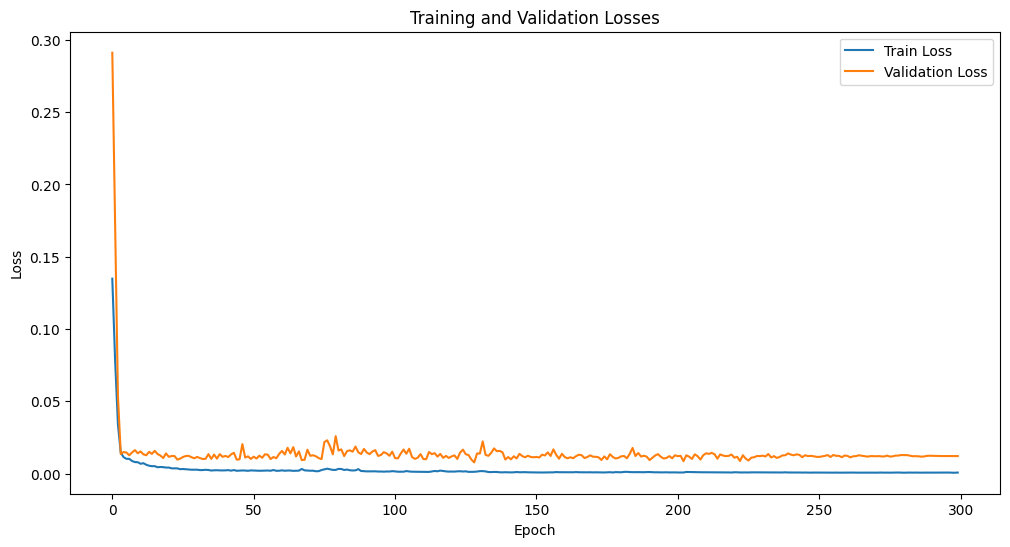

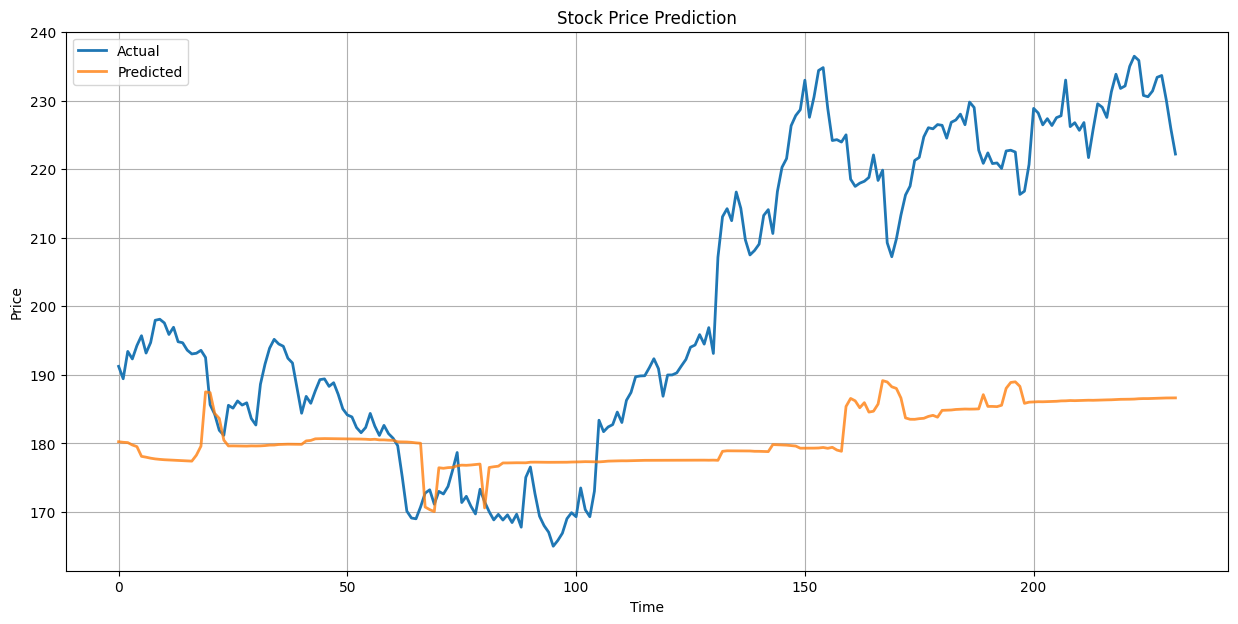


Performance Metrics:
MSE: 750.34
RMSE: 27.39
MAE: 21.96
MAPE: 10.24%


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class SelectiveScan(nn.Module):
    def __init__(self, d_model, d_state=64):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state

        # 입력 프로젝션
        self.in_proj = nn.Linear(d_model, d_state)

        # 상태 업데이트를 위한 게이트
        self.gate = nn.Linear(d_model, d_state)

        # 출력 프로젝션
        self.out_proj = nn.Linear(d_state, d_model)

    def forward(self, x):
        B, L, D = x.shape

        # 입력을 상태 공간으로 프로젝션
        x_state = self.in_proj(x)

        # 게이트 값 계산
        gate = torch.sigmoid(self.gate(x))

        # 상태 초기화
        h = torch.zeros(B, self.d_state, device=x.device)
        outputs = []

        for i in range(L):
            # 상태 업데이트
            h = h * (1 - gate[:, i]) + x_state[:, i] * gate[:, i]

            # 출력 생성
            y = self.out_proj(h)
            outputs.append(y)

        return torch.stack(outputs, dim=1)

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.2):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.selective_scan = SelectiveScan(d_model, d_state)
        self.dropout = nn.Dropout(dropout)
        self.output_linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.selective_scan(x)
        x = self.output_linear(x)
        x = self.dropout(x)
        return x + residual

class StockMambaModel(nn.Module):
    def __init__(self, input_size, d_model=128, d_state=64, n_layers=6, dropout=0.2):
        super().__init__()

        # 입력층 강화
        self.input_proj = nn.Sequential(
            nn.Linear(input_size, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
        )

        # Mamba 레이어
        self.layers = nn.ModuleList([
            MambaBlock(d_model, d_state, dropout)
            for _ in range(n_layers)
        ])

        # 출력층 강화
        self.norm = nn.LayerNorm(d_model)
        self.hidden1 = nn.Linear(d_model * 2, d_model)  # *2 for concatenated features
        self.hidden2 = nn.Linear(d_model, d_model//2)
        self.hidden3 = nn.Linear(d_model//2, d_model//4)
        self.output_proj = nn.Linear(d_model//4, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.input_proj(x)

        # Attention-like residual connections
        attention_weights = []
        for layer in self.layers:
            layer_output = layer(x)
            # Calculate attention weight using torch.matmul and softmax
            attention_weight = F.softmax(torch.matmul(layer_output, x.transpose(-2, -1)) / np.sqrt(x.size(-1)), dim=-1)
            attention_weights.append(attention_weight)
            # Applying attention weights differently to avoid dimension mismatch:
            x = layer_output + torch.matmul(attention_weight, x)

        x = self.norm(x)

        # Global context
        global_context = torch.mean(x, dim=1)
        last_state = x[:, -1, :]
        x = torch.cat([global_context, last_state], dim=-1)

        # Dense layers with skip connections
        h1 = F.gelu(self.hidden1(x))
        h1 = self.dropout(h1)
        h2 = F.gelu(self.hidden2(h1)) + h1[:, :h1.size(1)//2]
        h2 = self.dropout(h2)
        h3 = F.gelu(self.hidden3(h2))
        h3 = self.dropout(h3)

        out = self.output_proj(h3)
        return out

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_bollinger_bands(prices, window=20, std=2):
    ma = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper = ma + (std * std_dev)
    lower = ma - (std * std_dev)
    return upper, lower

def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    return true_range.rolling(window=period).mean()

def prepare_stock_data(symbol, start_date, end_date, sequence_length):
    stock = yf.download(symbol, start=start_date, end=end_date)
    data = stock.copy()

    # 기술적 지표 계산
    data['Returns'] = stock['Close'].pct_change()
    data['Log_Returns'] = np.log(stock['Close']).diff()
    data['MA5'] = stock['Close'].rolling(window=5).mean()
    data['MA20'] = stock['Close'].rolling(window=20).mean()
    data['MA50'] = stock['Close'].rolling(window=50).mean()
    data['MA200'] = stock['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(stock['Close'])
    data['MACD'], data['Signal'] = calculate_macd(stock['Close'])

    # 변동성 지표
    data['Volatility'] = stock['Close'].rolling(window=20).std()
    data['ATR'] = calculate_atr(stock)
    data['Upper_BB'], data['Lower_BB'] = calculate_bollinger_bands(stock['Close'])

    # 추세 지표
    data['Price_Momentum'] = stock['Close'] / stock['Close'].shift(20) - 1
    data['Volume_Momentum'] = stock['Volume'] / stock['Volume'].shift(20) - 1

    # 추가 특성
    data['High_Low_Ratio'] = stock['High'] / stock['Low']
    data['Close_Open_Ratio'] = stock['Close'] / stock['Open']

    # NaN 값 처리
    data = data.bfill().ffill()

    # 이상치 처리
    for column in data.columns:
        if data[column].dtype in [np.float64, np.float32]:
            q1 = data[column].quantile(0.01)
            q3 = data[column].quantile(0.99)
            iqr = q3 - q1
            data[column] = data[column].clip(lower=q1-1.5*iqr, upper=q3+1.5*iqr)

    # 스케일링
    price_scaler = MinMaxScaler()
    feature_scaler = StandardScaler()

    close_price = data['Close'].values.reshape(-1, 1)
    scaled_close = price_scaler.fit_transform(close_price)

    features = data.drop('Close', axis=1)
    scaled_features = feature_scaler.fit_transform(features)

    scaled_data = np.column_stack([scaled_close, scaled_features])

    # 시퀀스 생성
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_close[i + sequence_length][0])

    return np.array(X), np.array(y), price_scaler, feature_scaler

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        # 학습
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.float().to(device)
            batch_y = batch_y.float().to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            batch_y = batch_y.squeeze()

            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 검증
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.float().to(device)
                batch_y = batch_y.float().to(device)

                outputs = model(batch_X).squeeze()
                batch_y = batch_y.squeeze()

                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # 최고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f}')
            print(f'Val Loss: {val_loss:.4f}')
            print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

    # 최고 모델 복원
    model.load_state_dict(best_model)
    return train_losses, val_losses

def main():
    # 파라미터 설정
    symbol = "AAPL"
    sequence_length = 100
    batch_size = 16
    epochs = 300

    # 날짜 설정
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*5)

    # 데이터 준비
    X, y, price_scaler, feature_scaler = prepare_stock_data(
        symbol, start_date, end_date, sequence_length
    )

    # 데이터 분할
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 데이터로더
    train_data = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train)
    )
    test_data = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test)
    )

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size
    )

    # 모델 초기화
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = StockMambaModel(
        input_size=X.shape[2],
        d_model=128,
        d_state=64,
        n_layers=6,
        dropout=0.2
    ).to(device)

    # 학습 설정
    criterion = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=5e-4,
        weight_decay=1e-5,
        betas=(0.9, 0.999)
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-4,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        anneal_strategy='cos'
    )

    # 모델 학습
    train_losses, val_losses = train_model(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        epochs
    )

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 예측
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.float().to(device)
            output = model(batch_X).squeeze().cpu().numpy()
            predictions.extend(output.reshape(-1))

    predictions = np.array(predictions).reshape(-1, 1)
    predictions = price_scaler.inverse_transform(predictions)
    y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1))

    # 예측 결과 시각화
    plt.figure(figsize=(15, 7))
    plt.plot(y_test_original, label='Actual', linewidth=2)
    plt.plot(predictions, label='Predicted', linewidth=2, alpha=0.8)
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 성능 평가
    mse = np.mean((y_test_original - predictions) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test_original - predictions))
    mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

    print(f'\nPerformance Metrics:')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MAPE: {mape:.2f}%')

if __name__ == "__main__":
    main()